# 03 - Dataloader

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

from botocore.exceptions import ClientError
import boto3
import calendar
import io
from itertools import product
import numpy as np
import os
import pandas as pd
import random
import tifffile as tif
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
DATA_DIR = 'data'
BUCKET_NAME = 'drivendata-competition-biomassters-public-us'
RANDOM_STATE = 42

s3_client = boto3.client(
    's3',
    aws_access_key_id=os.environ['AWS_ACCESS_KEY_ID'],
    aws_secret_access_key=os.environ['AWS_SECRET_ACCESS_KEY']
)
s3_resource = boto3.resource(
    's3',
    aws_access_key_id=os.environ['AWS_ACCESS_KEY_ID'],
    aws_secret_access_key=os.environ['AWS_SECRET_ACCESS_KEY']
)
s3_bucket = s3_resource.Bucket(BUCKET_NAME)

month_map = {month: index for index, month in enumerate(calendar.month_name) if month}

In [3]:
def load_tif_from_s3(s3_bucket, key):
    try:
        object = s3_bucket.Object(key)
        img_data = object.get().get('Body').read()
        img = tif.imread(io.BytesIO(img_data))
        return reshape_tif(img)
        
    except ClientError as e:
        if e.response['Error']['Code'] == 'NoSuchKey':
            print("Error: No such key")
            img = None
            
def reshape_tif(img):
    if len(np.shape(img))==3:
        return np.moveaxis(img,2,0)
    elif len(np.shape(img))==2:
        return img
    else:
        raise ValueError(f"Unknown image shape {np.shape(img)}")


def download_from_s3(s3_bucket, key, out_path):
    try:
        s3_bucket.download_file(key, out_path)
    except ClientError as e:
        if e.response['Error']['Code'] == "404":
            print("The object does not exist.")
        else:
            raise

def load_tif(s3_bucket, key, out_path=None, local=False, reshape=False):
    if local:
        if not os.path.exists(out_path):
            download_from_s3(s3_bucket, key, out_path)
        img = tif.imread(out_path)
            
    else:
        img = load_tif_from_s3(s3_bucket, key)
    if reshape:
        return reshape_tif(img)
    else:
        return img
    

In [202]:
class DataLoader():
    
    def __init__(self, chip_ids, df_metadata, s3_bucket, local=False):
        self.chip_ids = chip_ids
        self.df_metadata = df_metadata
        self.s3_bucket = s3_bucket
        self.local = local
        
        self.dummy_s1_missing_value = 256
        self.dummy_s2_missing_value = -9999
        
        self.dummy_s1_missing_img = np.ones([4,256,256])*self.dummy_s1_missing_value
        self.dummy_s2_missing_img = np.ones([11,256,256])*self.dummy_s2_missing_value
        
        self.load_data()

    def load_data(self):
        self.X = []
        self.y = []
        for chip_id in self.chip_ids:
            self.X.append(self._load_chip_feature_data(chip_id))
            self.y.append(self._load_chip_target_data(chip_id))
        self.X = np.array(self.X)
        self.y = np.array(self.y)
                    
    def _get_chip_metadata(self, chip_id):
        return self.df_metadata[self.df_metadata.chip_id==chip_id]
    
    def _load_chip_feature_data(self, chip_id):
        img_list = []
        for idx, row in tqdm(self._get_chip_metadata(chip_id).iterrows(), position=0, leave=True):
            if type(row.filename) != str:
                if row.satellite=='S1':
                    img = self.dummy_s1_missing_img
                elif row.satellite=='S2':
                    img = self.dummy_s2_missing_img
                else:
                    raise ValueError("Unknown satellite value")
            else:
                key = f'{row.split}_features/{row.filename}'
                img = load_tif(self.s3_bucket, key, out_path=f'data/{key}', local=self.local, reshape=True)
            img_list.append(img)
        return np.concatenate(img_list, axis=0)
    
    def _load_chip_target_data(self, chip_id):
        filename = self._get_chip_metadata(chip_id).corresponding_agbm.iloc[0]
        key = f'train_agbm/{filename}'
        img = load_tif(self.s3_bucket, key, out_path=f'data/{key}', local=self.local)
        return img
        

In [53]:
df_metadata = pd.read_csv("data/metadata/features_metadata.csv",index_col=0)

all_chips = list(df_metadata.chip_id.unique())
train_chips = list(df_metadata[df_metadata.split=='train'].chip_id.unique())
test_chips = list(df_metadata[df_metadata.split=='test'].chip_id.unique())

In [54]:
random.seed(RANDOM_STATE)
train_chips_sample = random.sample(train_chips, 3)

In [73]:
dl = DataLoader(train_chips_sample, df_metadata, s3_bucket, local=True)
print(f'X: {np.shape(dl.X)}\ny: {np.shape(dl.y)}')

24it [00:00, 108.65it/s]
24it [00:00, 106.80it/s]
24it [00:00, 140.00it/s]


X: (3, 180, 256, 256)
y: (3, 256, 256)


In [74]:
np.shape(dl.X)

(3, 180, 256, 256)

In [75]:
# np.shape(np.concatenate(dl.X, axis=0))
# np.shape(np.array(dl.X))
type(np.array(dl.X)[1])

numpy.ndarray

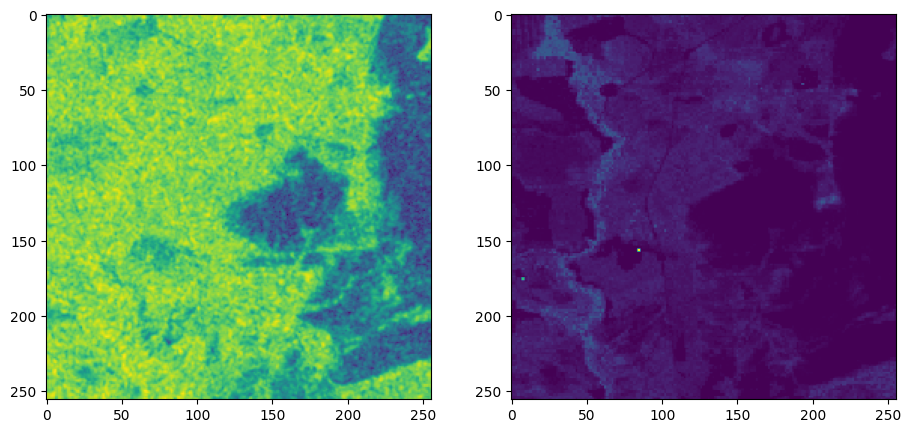

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
axes[0].imshow(dl.X[0][1,:,:])
axes[1].imshow(dl.y[0])

In [ ]:
# %timeit DataLoader(train_chips_sample, df_metadata, s3_bucket, local=True)
# %timeit DataLoader(train_chips_sample, df_metadata, s3_bucket, local=False)

## Testing high multi-channel convolution layer

In [43]:
def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2
    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net

def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

In [95]:
# set device
# device = torch.device('cuda:0') 
device = torch.device('cpu')

# define network
in_channels = np.shape(dl.X[0])[0]
out_channels = 1
model = [nn.ReflectionPad2d(3),
         nn.Conv2d(in_channels, out_channels, kernel_size=7, padding=0, bias=False),
         nn.InstanceNorm2d(out_channels),
         nn.ReLU(True)]
model = nn.Sequential(*model)
model = init_net(model).float()

# prepare input
input = torch.from_numpy(dl.X).to(device)

model.eval()

def forward(input):
    with torch.no_grad():
        return model(input)
        
output = forward(input.float())

In [97]:
%timeit forward(input.float())

873 ms ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Implement loader as Pytorch Dataset class

In [25]:
class BiomassDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, data, metadata, s3_bucket, local=True):
        self.data = data
        self.metadata = metadata
        self.s3_bucket = s3_bucket
        self.local = local
        
        self.dummy_s1_missing_value = 256
        self.dummy_s2_missing_value = -9999        
        self.dummy_s1_missing_img = np.ones([256,256,4])*self.dummy_s1_missing_value
        self.dummy_s2_missing_img = np.ones([256,256,11])*self.dummy_s2_missing_value
        
        self.transform_X = transforms.Compose(
            [
                # transforms.Resize((224, 224)),
                transforms.ToTensor(),
                # transforms.Normalize(
                #     mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                # ),
            ]
        )
        self.transform_y = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
    
    def __getitem__(self, index):
        chip_id = self.data['chip_id'].iloc[index]
        X = self._load_chip_feature_data(chip_id)
        y = self._load_chip_target_data(chip_id)
        self.X = self.transform_X(X)
        self.y = self.transform_y(y)
        return  {"chip_id": chip_id, "A": self.X, "B": self.y}

    def __len__(self):
        return len(self.data)
    
    def _get_chip_metadata(self, chip_id):
        return self.metadata[self.metadata.chip_id==chip_id]
    
    def _load_chip_feature_data(self, chip_id):
        img_channels = []
        for idx, row in self._get_chip_metadata(chip_id).iterrows():
            if type(row.filename) != str:
                if row.satellite=='S1':
                    img = self.dummy_s1_missing_img
                elif row.satellite=='S2':
                    img = self.dummy_s2_missing_img
                else:
                    raise ValueError("Unknown satellite value")
            else:
                key = f'{row.split}_features/{row.filename}'
                img = load_tif(self.s3_bucket, key, out_path=f'data/{key}', local=self.local)
            img_channels.append(img)
        ret = np.concatenate(img_channels, axis=2)
        return ret
    
    def _load_chip_target_data(self, chip_id):
        filename = self._get_chip_metadata(chip_id).corresponding_agbm.iloc[0]
        key = f'train_agbm/{filename}'
        img = load_tif(self.s3_bucket, key, out_path=f'data/{key}', local=self.local)
        return img

In [5]:
df_metadata = pd.read_csv("data/metadata/features_metadata.csv",index_col=0)

all_chips = list(df_metadata.chip_id.unique())
train_chips = list(df_metadata[df_metadata.split=='train'].chip_id.unique())
test_chips = list(df_metadata[df_metadata.split=='test'].chip_id.unique())

In [6]:
random.seed(RANDOM_STATE)
train_chips_sample = random.sample(train_chips, 5)

In [7]:
data = pd.DataFrame({'chip_id': train_chips_sample})
metadata = df_metadata[df_metadata.chip_id.isin(train_chips_sample)]
bm = BiomassDataset(data, metadata, s3_bucket)

chip_id: 84c58ac1, channel: 11
X: torch.Size([180, 256, 256])
y: torch.Size([1, 256, 256])


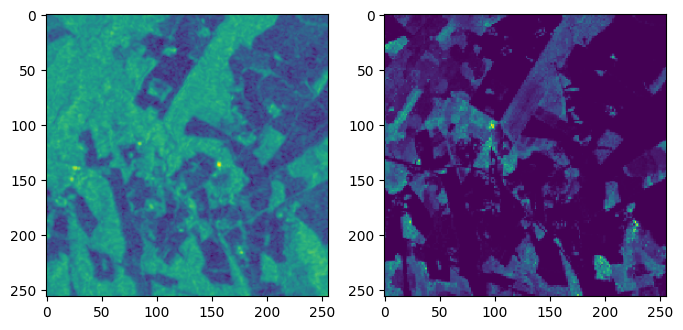

In [11]:
idx = 2
channel = 11
print(f'chip_id: {train_chips_sample[idx]}, channel: {channel}')
print(f"X: {np.shape(bm[idx]['A'])}\ny: {np.shape(bm[idx]['B'])}")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
axes[0].imshow(bm[idx]['A'][channel,:,:])
axes[1].imshow(bm[idx]['B'][0,:,:])

In [22]:
random.seed(RANDOM_STATE)
train_chips_sample = random.sample(train_chips, 15)

data = pd.DataFrame({'chip_id': train_chips_sample})
metadata = df_metadata[df_metadata.chip_id.isin(train_chips_sample)]
train_bm = BiomassDataset(data, metadata, s3_bucket)
train_dataloader = DataLoader(train_bm, batch_size=5)

In [30]:
for idx, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    print(idx, type(batch), batch.keys(), np.shape(batch['A']), np.shape(batch['B']))

 33%|████████████████████████████████████████████▋                                                                                         | 1/3 [00:02<00:04,  2.03s/it]

0 <class 'dict'> dict_keys(['chip_id', 'A', 'B']) torch.Size([5, 180, 256, 256]) torch.Size([5, 1, 256, 256])


 67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                            | 2/3 [00:03<00:01,  1.99s/it]

1 <class 'dict'> dict_keys(['chip_id', 'A', 'B']) torch.Size([5, 180, 256, 256]) torch.Size([5, 1, 256, 256])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.03s/it]

2 <class 'dict'> dict_keys(['chip_id', 'A', 'B']) torch.Size([5, 180, 256, 256]) torch.Size([5, 1, 256, 256])
